# Sensitivity Analysis of ReNeM CBA Components 

## Background

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

## Note 
Search this document for exclamation marks ! to find code chunks where the user can alter values to examine impacts under the sensitivity analysis

For the inflation-adjustment portion of this notebook to function, the user must have na excel document titled "Inflation.xlsx" that contains federal inflation data. 

If you'd like to adjust values for inflation, you can use the table below (data for inflation adjustments accessed at: https://data.bls.gov/timeseries/CUUR0000SA0) and the following methodology: 
- Identify the year to which you'd like the value(s) to be adjusted. Find the corresponding number in the "Total" column. This value will be called "Current Year" or "CYear". Define the CYear variable with this value in the code chunk below the table. 
- Identify the original year to which your value(s) was pegged. Find the corresponding number in the "Total" column. This value will be called "Past Year" or "PYear". Define the PYear variable with this value in the code chunk below the table. 
- Plug the value you'd like to adjust for inflation into the "VALUE" variable. 
- Plug the output inflation-adjusted value into the User Input codechunk.
- Re-run this process as many times as necessary to adjust all desired values for inflation. 

In [2]:
inflation = pd.read_excel("Inflation.xlsx")
inflation

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2,Total
0,2010,216.687,216.741,217.631,218.009,218.178,217.965,218.011,218.312,218.439,218.711,218.803,219.179,217.535,218.576,218.0555
1,2011,220.223,221.309,223.467,224.906,225.964,225.722,225.922,226.545,226.889,226.421,226.230,225.672,223.598,226.280,224.9390
2,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,228.850,230.338,229.5940
3,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.366,233.548,232.9570
4,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.384,237.088,236.7360
5,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,236.265,237.769,237.0170
6,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,238.778,241.237,240.0075
7,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,244.076,246.163,245.1195
8,2018,247.867,248.991,249.554,250.546,251.588,251.989,252.006,252.146,252.439,252.885,252.038,251.233,250.089,252.125,251.1070
9,2019,251.712,252.776,254.202,255.548,256.092,256.143,256.571,256.558,256.759,257.346,257.208,256.974,254.412,256.903,255.6575


In [3]:
# ! Adjust these as needed to update numerical estimates for inflation 

CYear = 270.9695          # !
PYear = 236.7360          # !
VALUE = 650               # ! 
VALUE * (CYear / PYear)

743.9940482224926

## User-defined inputs 
Here, the user can input the parameters that will serve as the benchmark for this sensitivity analysis. Each individual sensitivity analysis alters one of the below variables at a time and will assume that all non-altered variables have the quantity defined in this code chunk. Presently, the values defined in this code chunk are derived from the experience at the Kelly-Thompson Ranch and Bokariza-Drobac recharge sites as well as other local circumstances in the Pajaro Valley.

In [4]:
# ! Adjust these to capture different baseline conditions

n=25            # project lifespan 
Q=375           # acre feet of water recharged per year, uniform
V=650           # water replacement value
C=263           # volumetric pumping fee
lam=.5          # ReNeM rebate factor 
r=.06           # discount rate 
o=2             # number of ReNeM projects
s=0             # baseline payment value per recharge project when agency pays rechargers a baseline
a=10.3          # acrage dedicated exclusively to ReNeM
M=11000         # annual site operation & maintenance costs, labor & equipment (labor per acreage, equipment per site) 
#M_e=500         # annual site operation and maintenance costs per project related to equipment
#M_l=1000        # annual site operation and maintenance costs per acre related to labor
P=1780          # annual opportunity costs to the recharger 
F=847000        # fixed design and construction costs per ReNeM project 
tpc_ac=13400    # annual third party certification costs 
tpc_fc=3700     # one-time, fixed third party certification costs 
ipc=0           # incidental program operation costs 
B=0             # cost of obtaining excess water

## Other inputs 
In this section, I define the net present value (NPV) inputs used for this sensitivity analysis. Put another way, I define the NPV function generally and then show how it applies specifically to an agency, the rechargers, and the third-party certifier (TPC) in a ReNeM program. Broadly, NPV is generally based on discount rate (r), number of years (n), and annual benefits and costs.

In [5]:
def npv(r, n, annual_benefit, annual_cost):
    numerator = annual_benefit - annual_cost
    array = np.arange(0,n)
    denominator = (1+r)**array  
    return np.sum(numerator/denominator)

In [6]:
def npvs(n,Q,V,C,lam,r,o,s,a,M,P,F,tpc_ac,tpc_fc,ipc,B): 
    
    b_agency = Q * V
    c_agency = (Q * C * lam) + ipc + (o * s)
    npv_agency = npv(r,n,b_agency,c_agency) - (F * o)
    
    b_recharger = Q * C * lam + (s * o)
    c_recharger = M + (a * P) + B
    npv_recharger = npv(r,n,b_recharger,c_recharger)
    
    c_tpc = tpc_ac * o
    npv_tpc = npv(r,n,0,c_tpc) - (tpc_fc * o)
    
    return npv_agency, npv_recharger, npv_tpc

In [7]:
npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)

(940697.641804711, 270715.81786844315, -370549.5817440888)

## Analysis 

### Final Charts

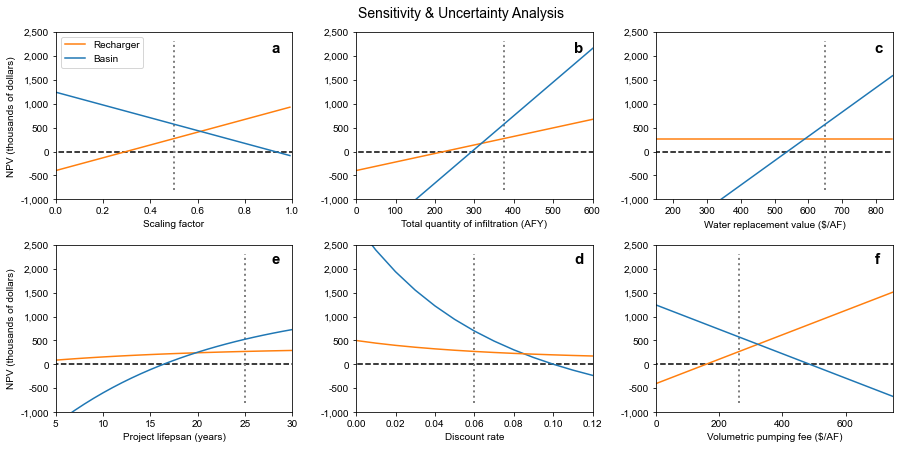

In [30]:
fig, ((ax4, ax2, ax6), (ax1, ax5, ax3)) = plt.subplots(2,3,  figsize = (15,7))
fig.subplots_adjust(wspace=.27,hspace=.27)
fig.suptitle('Sensitivity & Uncertainty Analysis', y = .93, fontsize = 14)

#Discount rate (r)
r5_range = np.arange(0,13)/100
est5_indx = np.where(r5_range==r)[0][0]
R5_npvs = np.zeros(len(r5_range))
A5_npvs = np.zeros(len(r5_range))
T5_npvs = np.zeros(len(r5_range))
for i, R in enumerate(r5_range):
    A5_npvs[i], R5_npvs[i], T5_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=R,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax5.hlines(0,-10000,1000,color="black",linestyle="dashed"  )
ax5.plot(r5_range, (A5_npvs + T5_npvs)/1e3, label = "Basin incurring TPC costs" )
ax5.plot(r5_range, R5_npvs/1e3, label = "Recharger")
ax5.vlines(r,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax.scatter(r5_range[est_indx],A_npvs[est_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax.scatter(r5_range[est_indx],R_npvs[est_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax.scatter(r5_range[est_indx],(A_npvs[est_indx] + T_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax5.set_xlim(0,.12)
ax5.set_ylim(-1000,2500)
#ax5.set_ylabel("NPV (thousands of dollars)", size = 10)
ax5.set_xlabel("Discount rate")
ax5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#Project lifespan 
N1_range = np.arange(4,35)
est1_indx = np.where(N1_range==n)[0][0]
R1_npvs = np.zeros(len(N1_range))
A1_npvs = np.zeros(len(N1_range))
T1_npvs = np.zeros(len(N1_range))
for i, N in enumerate(N1_range):
    A1_npvs[i], R1_npvs[i], T1_npvs = npvs(n=N,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax1.hlines(0,-10000,1000,color="black",linestyle="dashed"  )
#ax1.plot(N1_range, A1_npvs/1e3, label = "Basin" )
ax1.plot(N1_range, R1_npvs/1e3, color='#ff7f0e', label = "Recharger")
ax1.plot(N1_range, (A1_npvs + T1_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax1.vlines(n,-800, 2300, color="grey",linestyle = "dotted", linewidths=2, label = "Current assumed value")
#ax1.scatter(N1_range[est1_indx],A1_npvs[est1_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax1.scatter(N1_range[est1_indx],R1_npvs[est1_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax1.scatter(N1_range[est1_indx],(A1_npvs[est1_indx] + T1_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax1.set_ylabel("NPV (thousands of dollars)", size = 10)
ax1.set_xlabel("Project lifepsan (years)", size = 10)
ax1.set_xlim(5,30)
ax1.set_ylim(-1000,2500)
#ax1.legend(loc = "upper left")
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#Quantity of infiltration 
Q2_range = np.arange(0,625)
est2_indx = np.where(Q2_range==Q)[0][0]
R2_npvs = np.zeros(len(Q2_range))
A2_npvs = np.zeros(len(Q2_range))
T2_npvs = np.zeros(len(Q2_range))
for i, q in enumerate(Q2_range):
    A2_npvs[i], R2_npvs[i], T2_npvs = npvs(n=n,Q=q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)    
ax2.hlines(0,-10000,1000,color="black",linestyle="dashed"  )
#ax2.plot(Q2_range, A2_npvs/1e3, label = "Basin")
ax2.plot(Q2_range, R2_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax2.plot(Q2_range, (A2_npvs + T2_npvs)/1e3, color='#1f77b4', label = "Basin incurring TPC costs" )
ax2.vlines(Q,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax2.scatter(Q2_range[est2_indx],A2_npvs[est2_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax2.scatter(Q2_range[est2_indx],R2_npvs[est2_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax2.scatter(Q2_range[est2_indx],(A2_npvs[est2_indx] + T2_npvs)/1e3, edgecolor="green", s=70, marker="D")
#ax2.set_ylabel("NPV (thousands of dollars)")
ax2.set_xlabel("Total quantity of infiltration (AFY)", size = 10)
ax2.set_xlim(0,600)
ax2.set_ylim(-1000,2500)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax2.legend(loc = "upper left", size = 10)

#Volumetric pumping fee
C3_range = np.arange(0,750)
est3_indx = np.where(C3_range.round()==round(C,))
R3_npvs = np.zeros(len(C3_range))
A3_npvs = np.zeros(len(C3_range))
T3_npvs = np.zeros(len(C3_range))
for i, c in enumerate(C3_range):
    A3_npvs[i], R3_npvs[i], T3_npvs = npvs(n=n,Q=Q,V=V,C=c,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax3.vlines(Q,-1.2,2, linestyle='dashed') # ! I don't actually know what this is doing
ax3.hlines(0,-10000,1000,  color="black",linestyle="dashed"  )
#ax3.plot(C3_range, A3_npvs/1e3, label = "Basin")
ax3.plot(C3_range, R3_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax3.plot(C3_range, (A3_npvs + T3_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax3.vlines(C,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax3.scatter(C3_range[est3_indx],A3_npvs[est3_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax3.scatter(C3_range[est3_indx],R3_npvs[est3_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax3.scatter(C3_range[est3_indx],(A3_npvs[est3_indx] + T3_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax3.set_xlim(0,750)
ax3.set_ylim(-1000,2500)
#ax3.set_ylabel("NPV (thousands of dollars)", size = 10)
ax3.set_xlabel("Volumetric pumping fee ($/AF)", size = 10)
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#Scaling factor 
lam4_range = np.arange(0,100)/100
est4_indx = np.where(lam4_range.round(2)==lam)
R4_npvs = np.zeros(len(lam4_range))
A4_npvs = np.zeros(len(lam4_range))
T4_npvs = np.zeros(len(lam4_range))
for i, LAM in enumerate(lam4_range):
    A4_npvs[i], R4_npvs[i], T4_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=LAM,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax4.vlines(Q,-1.2,2, linestyle='dashed') # ! I don't actually know what this is doing
ax4.hlines(0,-10000,1000, color="black",linestyle="dashed"  )
#ax4.plot(lam4_range, A4_npvs/1e3, label = "Basin")
ax4.plot(lam4_range, R4_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax4.plot(lam4_range, (A4_npvs + T4_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax4.vlines(lam,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax4.scatter(lam4_range[est4_indx],A4_npvs[est4_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax4.scatter(lam4_range[est4_indx],R4_npvs[est4_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax4.scatter(lam4_range[est4_indx],(A4_npvs[est4_indx] + T4_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax4.set_xlim(0,1)
ax4.set_ylim(-1000,2500)
ax4.set_ylabel("NPV (thousands of dollars)", size = 10)
ax4.set_xlabel("Scaling factor", size = 10)
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax4.legend(loc = "upper left")

#Water replacement value 
V6_range = np.arange(150,850)
est6_indx = np.where(V6_range.round()==round(V,))
R6_npvs = np.zeros(len(V6_range))
A6_npvs = np.zeros(len(V6_range))
T6_npvs = np.zeros(len(V6_range))
for i, v in enumerate(V6_range):
    A6_npvs[i], R6_npvs[i], T6_npvs = npvs(n=n,Q=Q,V=v,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax6.vlines(Q,-1.2,2, linestyle='dashed') # ! I don't actually know what this is doing
ax6.hlines(0,-10000,10000,  color="black",linestyle="dashed"  )
#ax6.plot(V6_range, A6_npvs/1e3, label = "Basin")
ax6.plot(V6_range, R6_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax6.plot(V6_range, (A6_npvs + T6_npvs)/1e3, color='#1f77b4', label = "Basin incurring TPC costs" )
ax6.vlines(V,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax6.scatter(V6_range[est6_indx],A6_npvs[est6_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax6.scatter(V6_range[est6_indx],R6_npvs[est6_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax6.scatter(V6_range[est6_indx],(A6_npvs[est6_indx] + T6_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax6.set_xlim(150,850)
ax6.set_ylim(-1000,2500)
#ax6.set_ylabel("NPV (thousands of dollars)", size = 10)
ax6.set_xlabel("Water replacement value ($/AF)", size = 10)
ax6.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## add panel labels
fig.text(0.325,.84,"a",weight="bold",size=15)
fig.text(0.605,.84,"b",weight="bold",size=15)
fig.text(0.883,.84,"c",weight="bold",size=15)
fig.text(0.605,.42,"d",weight="bold",size=15)
fig.text(0.325,.42,"e",weight="bold",size=15)
fig.text(0.883,.42,"f",weight="bold",size=15)

fig.savefig("sensitivity.png")
fig.savefig("sensitivity.pdf")

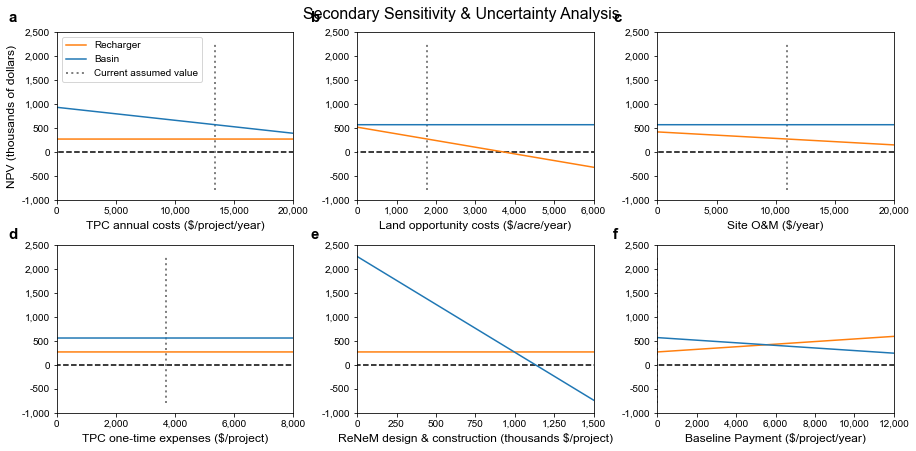

In [9]:
fig, ((ax1, ax2, ax3), (ax8, ax7, ax5)) = plt.subplots(2,3,  figsize = (15,7))
fig.subplots_adjust(wspace=.27,hspace=.27)
fig.suptitle('Secondary Sensitivity & Uncertainty Analysis', y = .93, fontsize = 16)

#TPC Annual Costs 
tpc_ac1_range = np.arange(0,25000)
est_indx = np.where(tpc_ac1_range.round() == round(tpc_ac,))
R1_npvs = np.zeros(len(tpc_ac1_range))
A1_npvs = np.zeros(len(tpc_ac1_range))
T1_npvs = np.zeros(len(tpc_ac1_range))
for i, TPC_AC in enumerate(tpc_ac1_range):
    A1_npvs[i], R1_npvs[i], T1_npvs[i] = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=TPC_AC,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax1.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax1.plot(tpc_ac1_range, A1_npvs/1e3, label = "Basin")
ax1.plot(tpc_ac1_range, R1_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax1.plot(tpc_ac1_range, (A1_npvs + T1_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax1.vlines(tpc_ac,-800, 2300, color="grey",linestyle = "dotted", linewidths=2, label = "Current assumed value")
ax1.set_ylabel("NPV (thousands of dollars)", size = 12)
ax1.set_xlabel("TPC annual costs ($/project/year)", size = 12)
ax1.set_xlim(0,20000)
ax1.set_ylim(-1000,2500)
ax1.legend(loc = "upper left")
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#Opportunity Cost 
P2_range = np.arange(0,7500)
est_indx = np.where(P2_range == P)
R2_npvs = np.zeros(len(P2_range))
A2_npvs = np.zeros(len(P2_range))
T2_npvs = np.zeros(len(P2_range))
for i, p in enumerate(P2_range):
    A2_npvs[i], R2_npvs[i], T2_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=p,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax2.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax2.plot(P2_range, A2_npvs/1e3, label = "Basin")
ax2.plot(P2_range, R2_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax2.plot(P2_range, (A2_npvs + T2_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax2.vlines(P,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax2.set_ylabel("NPV (thousands of dollars)")
ax2.set_xlabel("Land opportunity costs ($/acre/year)", size = 12)
ax2.set_xlim(0,6000)
ax2.set_ylim(-1000,2500)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax2.legend(loc="upper right")

#Baseline payment 
s5_range = np.arange(-10,12000)
est5_indx = np.where(s5_range.round()==round(s,))
R5_npvs = np.zeros(len(s5_range))
A5_npvs = np.zeros(len(s5_range))
T5_npvs = np.zeros(len(s5_range))
for i, S in enumerate(s5_range):
    A5_npvs[i], R5_npvs[i], T5_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=S,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax5.hlines(0,-10000,12000,color="black",linestyle="dashed"  )
#ax5.plot(s5_range, A5_npvs/1e3, label = "Basin")
ax5.plot(s5_range, R5_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax5.plot(s5_range, (A5_npvs + T5_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax5.vlines(s,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
ax5.set_xlim(0,12000)
ax5.set_ylim(-1000,2500)
#ax5.set_ylabel("NPV (thousands of dollars)", size = 10)
ax5.set_xlabel("Baseline Payment ($/project/year)", size = 12)
ax5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax5.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#O&M
M3_range = np.arange(0,21000)
est_indx = np.where(M3_range.round()==(M,))
R3_npvs = np.zeros(len(M3_range))
A3_npvs = np.zeros(len(M3_range))
T3_npvs = np.zeros(len(M3_range))
for i, m in enumerate(M3_range):
    A3_npvs[i], R3_npvs[i], T3_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=m,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax3.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax3.plot(Ml3_range, A3_npvs/1e3, label = "Basin")
ax3.plot(M3_range, (A3_npvs + T3_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax3.plot(M3_range, R3_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax3.vlines(M,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax3.scatter(Ml3_range[est_indx],A3_npvs[est_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax3.scatter(Ml3_range[est_indx],R3_npvs[est_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax3.scatter(Ml3_range[est_indx],(A3_npvs[est_indx] + T3_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax3.set_xlim(0,20000)
ax3.set_ylim(-1000,2500)
#ax3.set_ylabel("NPV (thousands of dollars)")
ax3.set_xlabel("Site O&M ($/year)", size = 12)
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax3.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

##O&M Equipment
#Me4_range = np.arange(0,5000)
#est_indx = np.where(Me4_range.round()==(M_e,))
#R4_npvs = np.zeros(len(Me4_range))
#A4_npvs = np.zeros(len(Me4_range))
#T4_npvs = np.zeros(len(Me4_range))
#for i, m_e in enumerate(Me4_range):
#    A4_npvs[i], R4_npvs[i], T4_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M_e=m_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax4.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
##ax4.plot(Me4_range, A4_npvs/1e3, label = "Basin")
#ax4.plot(Me4_range, (A4_npvs + T4_npvs)/1e3, color='#1f77b4', label = "Basin" )
#ax4.plot(Me4_range, R4_npvs/1e3, color='#ff7f0e', label = "Recharger" )
#ax4.vlines(M_e,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax4.set_xlim(0,1500)
#ax4.set_ylim(-1000,2500)
#ax4.set_ylabel("NPV (thousands of dollars)", size = 12)
#ax4.set_xlabel("Site supplies O&M ($/project/year)", size = 12)
##ax4.legend(loc="upper right")

##Acres 
#a6_range = np.arange(0,30)
#est6_indx = np.where(a6_range == a)
#R6_npvs = np.zeros(len(a6_range))
#A6_npvs = np.zeros(len(a6_range))
#T6_npvs = np.zeros(len(a6_range))
#for i, A in enumerate(a6_range):
#    A6_npvs[i], R6_npvs[i], T6_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=A,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax6.hlines(0,-10000,10000,  color="black",linestyle="dashed"  )
##ax6.plot(a6_range, A6_npvs/1e3, label = "Basin")
#ax6.plot(a6_range, R6_npvs/1e3, color='#ff7f0e', label = "Recharger" )
#ax6.plot(a6_range, (A6_npvs + T6_npvs)/1e3, color='#1f77b4', label = "Basin" )
#ax6.vlines(a,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax6.set_xlim(0,18)
#ax6.set_ylim(-1000,2500)
#ax6.set_xlabel("ReNeM acreage", size = 12)

#Fixed ReNeM project design costs 
F7_range = np.arange(0,2000000)
est_indx = np.where(F7_range == F)
R7_npvs = np.zeros(len(F7_range))
A7_npvs = np.zeros(len(F7_range))
T7_npvs = np.zeros(len(F7_range))
for i, f in enumerate(F7_range):
    A7_npvs[i], R7_npvs[i], T7_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=f,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax7.hlines(0,-10000,3000000,color="black",linestyle="dashed"  )
#ax2.plot(P2_range, A2_npvs/1e3, label = "Basin")
ax7.plot(F7_range/1e3, R7_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax7.plot(F7_range/1e3, (A7_npvs + T7_npvs)/1e3, color ='#1f77b4', label = "Basin" )
ax7.vlines(F,-800, 2300, color="grey", linestyle = "dotted", linewidths=2)
#ax7.set_ylabel("NPV (thousands of dollars)")
ax7.set_xlabel("ReNeM design & construction (thousands $/project)", size = 12)
ax7.set_xlim(0,1_500_000/1e3)
ax7.set_ylim(-1000,2500)
#ax7.legend(loc="upper right")
ax7.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax7.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#One-time TPC expenses 
tpc_fc8_range = np.arange(0,8000)
est_indx = np.where(tpc_fc8_range == tpc_fc)
R8_npvs = np.zeros(len(tpc_fc8_range))
A8_npvs = np.zeros(len(tpc_fc8_range))
T8_npvs = np.zeros(len(tpc_fc8_range))
for i, TPC_FC in enumerate(tpc_fc8_range):
    A8_npvs[i], R8_npvs[i], T8_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=TPC_FC,ipc=ipc,B=B)
ax8.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax8.plot(tpc_fc8_range, A8_npvs/1e3, label = "Basin")
ax8.plot(tpc_fc8_range, R8_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax8.plot(tpc_fc8_range, (A8_npvs + T8_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax8.vlines(tpc_fc,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax8.set_ylabel("NPV (thousands of dollars)")
ax8.set_xlabel("TPC one-time expenses ($/project)", size = 12)
ax8.set_xlim(0,8000)
ax8.set_ylim(-1000,2500)
ax8.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax8.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax8.legend(loc="upper right")

## add panel labels

fig.text(0.08,.9,"a",weight="bold",size=15)
fig.text(0.36,.9,"b",weight="bold",size=15)
fig.text(0.64,.9,"c",weight="bold",size=15)
fig.text(0.08,.47,"d",weight="bold",size=15)
fig.text(0.36,.47,"e",weight="bold",size=15)
fig.text(0.64,.47,"f",weight="bold",size=15)

fig.savefig("sensitivity_leftovers.png")
fig.savefig("sensitivity_leftovers.pdf")

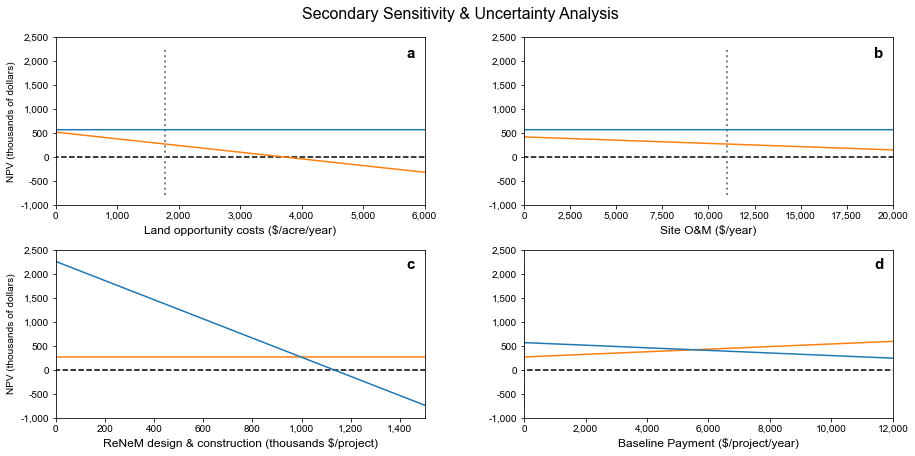

In [25]:
fig, ((ax2, ax3), (ax7, ax5)) = plt.subplots(2,2,  figsize = (15,7))
fig.subplots_adjust(wspace=.27,hspace=.27)
fig.suptitle('Secondary Sensitivity & Uncertainty Analysis', y = .94,x =.50, fontsize = 16)

ax1.axis("off")

#Opportunity Cost 
P2_range = np.arange(0,7500)
est_indx = np.where(P2_range == P)
R2_npvs = np.zeros(len(P2_range))
A2_npvs = np.zeros(len(P2_range))
T2_npvs = np.zeros(len(P2_range))
for i, p in enumerate(P2_range):
    A2_npvs[i], R2_npvs[i], T2_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=p,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax2.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax2.plot(P2_range, A2_npvs/1e3, label = "Basin")
ax2.plot(P2_range, R2_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax2.plot(P2_range, (A2_npvs + T2_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax2.vlines(P,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
ax2.set_ylabel("NPV (thousands of dollars)")
ax2.set_xlabel("Land opportunity costs ($/acre/year)", size = 12)
ax2.set_xlim(0,6000)
ax2.set_ylim(-1000,2500)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax2.legend(loc="upper right")

#Baseline payment 
s5_range = np.arange(-10,12000)
est5_indx = np.where(s5_range.round()==round(s,))
R5_npvs = np.zeros(len(s5_range))
A5_npvs = np.zeros(len(s5_range))
T5_npvs = np.zeros(len(s5_range))
for i, S in enumerate(s5_range):
    A5_npvs[i], R5_npvs[i], T5_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=S,a=a,M=M,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax5.hlines(0,-10000,12000,color="black",linestyle="dashed"  )
#ax5.plot(s5_range, A5_npvs/1e3, label = "Basin")
ax5.plot(s5_range, R5_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax5.plot(s5_range, (A5_npvs + T5_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax5.vlines(s,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
ax5.set_xlim(0,12000)
ax5.set_ylim(-1000,2500)
#ax5.set_ylabel("NPV (thousands of dollars)", size = 10)
ax5.set_xlabel("Baseline Payment ($/project/year)", size = 12)
ax5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax5.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#O&M
M3_range = np.arange(0,21000)
est_indx = np.where(M3_range.round()==(M,))
R3_npvs = np.zeros(len(M3_range))
A3_npvs = np.zeros(len(M3_range))
T3_npvs = np.zeros(len(M3_range))
for i, m in enumerate(M3_range):
    A3_npvs[i], R3_npvs[i], T3_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=m,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax3.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
#ax3.plot(Ml3_range, A3_npvs/1e3, label = "Basin")
ax3.plot(M3_range, (A3_npvs + T3_npvs)/1e3, color='#1f77b4', label = "Basin" )
ax3.plot(M3_range, R3_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax3.vlines(M,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax3.scatter(Ml3_range[est_indx],A3_npvs[est_indx]/1e3, edgecolor="blue", s=70, marker="D")
#ax3.scatter(Ml3_range[est_indx],R3_npvs[est_indx]/1e3, edgecolor="orange", s=70, marker="D")
#ax3.scatter(Ml3_range[est_indx],(A3_npvs[est_indx] + T3_npvs)/1e3, edgecolor="green", s=70, marker="D")
ax3.set_xlim(0,20000)
ax3.set_ylim(-1000,2500)
#ax3.set_ylabel("NPV (thousands of dollars)")
ax3.set_xlabel("Site O&M ($/year)", size = 12)
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax3.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

##O&M Equipment
#Me4_range = np.arange(0,5000)
#est_indx = np.where(Me4_range.round()==(M_e,))
#R4_npvs = np.zeros(len(Me4_range))
#A4_npvs = np.zeros(len(Me4_range))
#T4_npvs = np.zeros(len(Me4_range))
#for i, m_e in enumerate(Me4_range):
#    A4_npvs[i], R4_npvs[i], T4_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M_e=m_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax4.hlines(0,-10000,100000,color="black",linestyle="dashed"  )
##ax4.plot(Me4_range, A4_npvs/1e3, label = "Basin")
#ax4.plot(Me4_range, (A4_npvs + T4_npvs)/1e3, color='#1f77b4', label = "Basin" )
#ax4.plot(Me4_range, R4_npvs/1e3, color='#ff7f0e', label = "Recharger" )
#ax4.vlines(M_e,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax4.set_xlim(0,1500)
#ax4.set_ylim(-1000,2500)
#ax4.set_ylabel("NPV (thousands of dollars)", size = 12)
#ax4.set_xlabel("Site supplies O&M ($/project/year)", size = 12)
##ax4.legend(loc="upper right")

##Acres 
#a6_range = np.arange(0,30)
#est6_indx = np.where(a6_range == a)
#R6_npvs = np.zeros(len(a6_range))
#A6_npvs = np.zeros(len(a6_range))
#T6_npvs = np.zeros(len(a6_range))
#for i, A in enumerate(a6_range):
#    A6_npvs[i], R6_npvs[i], T6_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=A,M_e=M_e,M_l=M_l,P=P,F=F,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
#ax6.hlines(0,-10000,10000,  color="black",linestyle="dashed"  )
##ax6.plot(a6_range, A6_npvs/1e3, label = "Basin")
#ax6.plot(a6_range, R6_npvs/1e3, color='#ff7f0e', label = "Recharger" )
#ax6.plot(a6_range, (A6_npvs + T6_npvs)/1e3, color='#1f77b4', label = "Basin" )
#ax6.vlines(a,-800, 2300, color="grey",linestyle = "dotted", linewidths=2)
#ax6.set_xlim(0,18)
#ax6.set_ylim(-1000,2500)
#ax6.set_xlabel("ReNeM acreage", size = 12)

#Fixed ReNeM project design costs 
F7_range = np.arange(0,2_000_000,100)
est_indx = np.where(F7_range == F)
R7_npvs = np.zeros(len(F7_range))
A7_npvs = np.zeros(len(F7_range))
T7_npvs = np.zeros(len(F7_range))
for i, f in enumerate(F7_range):
    A7_npvs[i], R7_npvs[i], T7_npvs = npvs(n=n,Q=Q,V=V,C=C,lam=lam,r=r,o=o,s=s,a=a,M=M,P=P,F=f,tpc_ac=tpc_ac,tpc_fc=tpc_fc,ipc=ipc,B=B)
ax7.hlines(0,-10000,3000000,color="black",linestyle="dashed"  )
#ax2.plot(P2_range, A2_npvs/1e3, label = "Basin")
ax7.plot(F7_range/1e3, R7_npvs/1e3, color='#ff7f0e', label = "Recharger" )
ax7.plot(F7_range/1e3, (A7_npvs + T7_npvs)/1e3, color ='#1f77b4', label = "Basin" )
ax7.vlines(F,-800, 2300, color="grey", linestyle = "dotted", linewidths=2)
ax7.set_ylabel("NPV (thousands of dollars)")
ax7.set_xlabel("ReNeM design & construction (thousands $/project)", size = 12)
ax7.set_xlim(0,1_500_000/1e3)
ax7.set_ylim(-1000,2500)
#ax7.legend(loc="upper right")
ax7.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax7.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax8.axis("off")

## add panel labels
fig.text(0.45,.84,"a",weight="bold",size=15)
fig.text(0.883,.84,"b",weight="bold",size=15)
fig.text(0.45,.42,"c",weight="bold",size=15)
fig.text(0.883,.42,"d",weight="bold",size=15)

fig.savefig("sensitivity_leftovers_2.png")
fig.savefig("sensitivity_leftovers_2.pdf")